In [ ]:
import os

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import utils
import paths
from app import segmentation

/home/hsi/venv_tmp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image = utils.get_input_and_label(paths.PATH_LIST, 0, 2)[0]

(401, 630, 1)


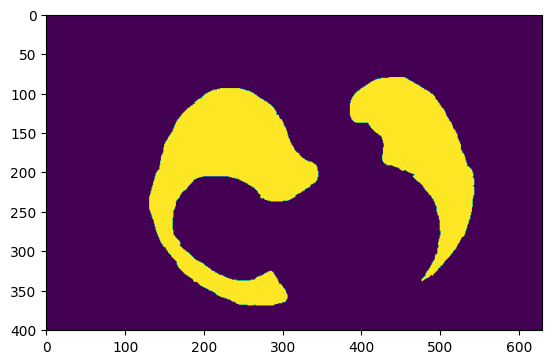

In [3]:
label = utils.get_input_and_label(paths.PATH_LIST, 0, 2)[1]
print(label.shape)
plt.imshow(label)

In [4]:
np.unique(label)

array([False,  True])

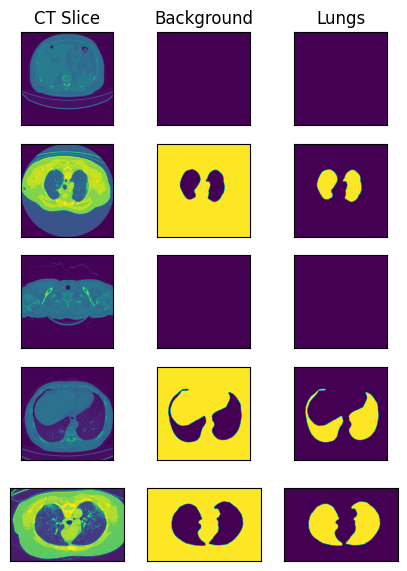

In [5]:
utils.visualize_data()

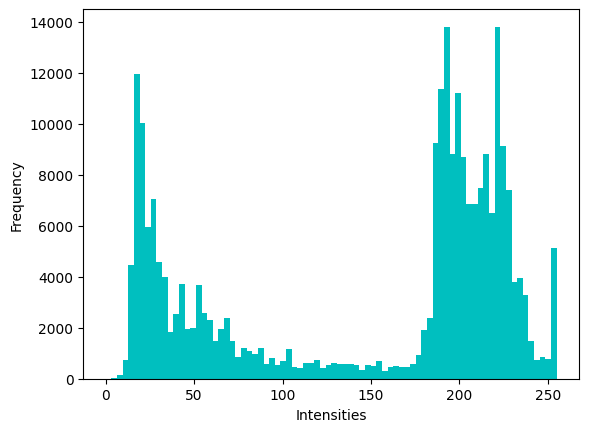

In [6]:
utils.plot_histogram(image)

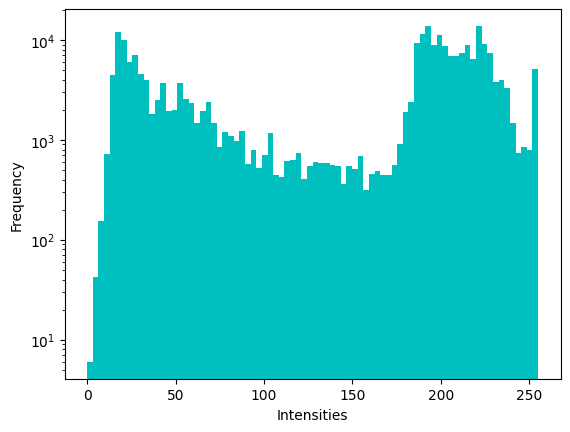

In [7]:
utils.plot_histogram(image, log=True)

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize((512, 512))])

In [10]:
volume_sizes = utils.get_volume_sizes(paths.PATH_LIST)

In [11]:
train_dataset = utils.CTScansDataset(volume_sizes=volume_sizes, transform=transform, mode='train')
valid_dataset = utils.CTScansDataset(volume_sizes=volume_sizes, transform=transform, mode='valid')
test_dataset = utils.CTScansDataset(volume_sizes=volume_sizes, transform=transform, mode='test')

In [12]:
len(train_dataset)

2279

In [13]:
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 2279
Valid size: 333
Test size: 908


In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [15]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 1
ACTIVATION = 'sigmoid' 
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=1,
    classes=NUM_CLASSES, 
    activation=ACTIVATION,
)

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [16]:
device = utils.get_device()
device

device(type='cuda')

In [17]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=False,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=False,
)

In [18]:
TRAINING = True
EPOCHS = 100

In [19]:
torch.backends.cudnn.enabled = False

In [ ]:
%%time

writer = SummaryWriter()
best_iou_score_val = 0.0
best_dice_loss_val = float('inf')
best_iou_score_train = 0.0
best_dice_loss_train = float('inf')

train_logs_list, valid_logs_list = [], []

for epoch in range(0, EPOCHS):
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(tqdm(train_dataloader))
    writer.add_scalar("Dice Loss/train", train_logs['dice_loss'], epoch)
    writer.add_scalar("IOU Score/train", train_logs['iou_score'], epoch)

    valid_logs = valid_epoch.run(valid_dataloader)
    writer.add_scalar("Dice Loss/val", valid_logs['dice_loss'], epoch)
    writer.add_scalar("IOU Score/val", valid_logs['iou_score'], epoch)

    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    print(f"Train loss: {train_logs['dice_loss']:.5f}, iou_score: {train_logs['iou_score']:.5f}")
    print(f"Valid loss: {valid_logs['dice_loss']:.5f}, iou_score: {valid_logs['iou_score']:.5f}")
    if best_iou_score_val < valid_logs['iou_score']:
        best_iou_score_val = valid_logs['iou_score']
        best_dice_loss_val = valid_logs['dice_loss']
        best_iou_score_train = train_logs['iou_score']
        best_dice_loss_train = train_logs['dice_loss']

        if not os.path.exists(paths.MODEL_PATH):
            os.makedirs(paths.MODEL_PATH)
        utils.save_model_checkpoint(model, paths.MODEL_PATH, 'best_model_dlv3p.pth')
        tqdm.write('Model saved!')
print(f'Best train loss {best_dice_loss_train:.5f}')
print(f'Best validation loss {best_dice_loss_val:.5f}')
print(f'Best train IoU score {best_iou_score_train:.5f}')
print(f'Best validation IoU score {best_iou_score_val:.5f}')
writer.flush()
writer.close()


Epoch: 0


100%|██████████| 285/285 [00:49<00:00,  5.72it/s]


Train loss: 0.08752, iou_score: 0.90567
Valid loss: 0.10498, iou_score: 0.82647
Model saved!

Epoch: 1


100%|██████████| 285/285 [00:48<00:00,  5.86it/s]


Train loss: 0.02175, iou_score: 0.96168
Valid loss: 0.02074, iou_score: 0.96226
Model saved!

Epoch: 2


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.01718, iou_score: 0.96849
Valid loss: 0.02219, iou_score: 0.96026

Epoch: 3


100%|██████████| 285/285 [00:49<00:00,  5.81it/s]


Train loss: 0.01776, iou_score: 0.96695
Valid loss: 0.02376, iou_score: 0.95601

Epoch: 4


100%|██████████| 285/285 [00:49<00:00,  5.79it/s]


Train loss: 0.01687, iou_score: 0.96832
Valid loss: 0.38072, iou_score: 0.45544

Epoch: 5


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.02566, iou_score: 0.95265
Valid loss: 0.02146, iou_score: 0.95982

Epoch: 6


100%|██████████| 285/285 [00:48<00:00,  5.93it/s]


Train loss: 0.01598, iou_score: 0.96964
Valid loss: 0.02013, iou_score: 0.96194

Epoch: 7


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.01483, iou_score: 0.97161
Valid loss: 0.01846, iou_score: 0.96490
Model saved!

Epoch: 8


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.01496, iou_score: 0.97132
Valid loss: 0.01839, iou_score: 0.96481

Epoch: 9


100%|██████████| 285/285 [00:47<00:00,  5.96it/s]


Train loss: 0.01841, iou_score: 0.96728
Valid loss: 0.02589, iou_score: 0.95167

Epoch: 10


100%|██████████| 285/285 [00:48<00:00,  5.83it/s]


Train loss: 0.01532, iou_score: 0.97058
Valid loss: 0.01977, iou_score: 0.96222

Epoch: 11


100%|██████████| 285/285 [00:48<00:00,  5.89it/s]


Train loss: 0.01407, iou_score: 0.97283
Valid loss: 0.01875, iou_score: 0.96392

Epoch: 12


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.01473, iou_score: 0.97155
Valid loss: 0.01695, iou_score: 0.96739
Model saved!

Epoch: 13


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.01367, iou_score: 0.97350
Valid loss: 0.01845, iou_score: 0.96437

Epoch: 14


100%|██████████| 285/285 [00:48<00:00,  5.93it/s]


Train loss: 0.01468, iou_score: 0.97159
Valid loss: 0.01855, iou_score: 0.96412

Epoch: 15


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.02865, iou_score: 0.94870
Valid loss: 0.07024, iou_score: 0.87793

Epoch: 16


100%|██████████| 285/285 [00:47<00:00,  5.95it/s]


Train loss: 0.01838, iou_score: 0.96467
Valid loss: 0.02134, iou_score: 0.95924

Epoch: 17


100%|██████████| 285/285 [00:48<00:00,  5.90it/s]


Train loss: 0.01530, iou_score: 0.97044
Valid loss: 0.02111, iou_score: 0.95964

Epoch: 18


100%|██████████| 285/285 [00:48<00:00,  5.90it/s]


Train loss: 0.01550, iou_score: 0.97007
Valid loss: 0.02098, iou_score: 0.95971

Epoch: 19


100%|██████████| 285/285 [00:47<00:00,  5.96it/s]


Train loss: 0.01394, iou_score: 0.97293
Valid loss: 0.01868, iou_score: 0.96391

Epoch: 20


100%|██████████| 285/285 [00:48<00:00,  5.89it/s]


Train loss: 0.01351, iou_score: 0.97375
Valid loss: 0.01916, iou_score: 0.96298

Epoch: 21


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.01321, iou_score: 0.97429
Valid loss: 0.01992, iou_score: 0.96147

Epoch: 22


100%|██████████| 285/285 [00:47<00:00,  5.94it/s]


Train loss: 0.01309, iou_score: 0.97451
Valid loss: 0.01878, iou_score: 0.96366

Epoch: 23


100%|██████████| 285/285 [00:47<00:00,  5.98it/s]


Train loss: 0.01319, iou_score: 0.97430
Valid loss: 0.01719, iou_score: 0.96664

Epoch: 24


100%|██████████| 285/285 [00:47<00:00,  5.97it/s]


Train loss: 0.01293, iou_score: 0.97479
Valid loss: 0.01845, iou_score: 0.96418

Epoch: 25


100%|██████████| 285/285 [00:48<00:00,  5.90it/s]


Train loss: 0.01285, iou_score: 0.97495
Valid loss: 0.01828, iou_score: 0.96451

Epoch: 26


100%|██████████| 285/285 [00:47<00:00,  5.96it/s]


Train loss: 0.01309, iou_score: 0.97446
Valid loss: 0.01721, iou_score: 0.96656

Epoch: 27


100%|██████████| 285/285 [00:48<00:00,  5.89it/s]


Train loss: 0.01261, iou_score: 0.97536
Valid loss: 0.01966, iou_score: 0.96180

Epoch: 28


100%|██████████| 285/285 [00:49<00:00,  5.71it/s]


Train loss: 0.01418, iou_score: 0.97248
Valid loss: 0.04622, iou_score: 0.91642

Epoch: 29


100%|██████████| 285/285 [00:48<00:00,  5.89it/s]


Train loss: 0.01621, iou_score: 0.96861
Valid loss: 0.01984, iou_score: 0.96171

Epoch: 30


100%|██████████| 285/285 [00:47<00:00,  6.01it/s]


Train loss: 0.01309, iou_score: 0.97445
Valid loss: 0.01698, iou_score: 0.96699

Epoch: 31


100%|██████████| 285/285 [00:47<00:00,  6.04it/s]


Train loss: 0.01259, iou_score: 0.97541
Valid loss: 0.01708, iou_score: 0.96673

Epoch: 32


100%|██████████| 285/285 [00:47<00:00,  5.98it/s]


Train loss: 0.01226, iou_score: 0.97604
Valid loss: 0.01646, iou_score: 0.96793
Model saved!

Epoch: 33


100%|██████████| 285/285 [00:48<00:00,  5.89it/s]


Train loss: 0.01588, iou_score: 0.96991
Valid loss: 0.20298, iou_score: 0.67541

Epoch: 34


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.02021, iou_score: 0.96138
Valid loss: 0.02723, iou_score: 0.94817

Epoch: 35


100%|██████████| 285/285 [00:47<00:00,  6.01it/s]


Train loss: 0.01404, iou_score: 0.97263
Valid loss: 0.01826, iou_score: 0.96454

Epoch: 36


100%|██████████| 285/285 [00:47<00:00,  6.03it/s]


Train loss: 0.01319, iou_score: 0.97425
Valid loss: 0.02029, iou_score: 0.96068

Epoch: 37


100%|██████████| 285/285 [00:47<00:00,  5.96it/s]


Train loss: 0.01288, iou_score: 0.97484
Valid loss: 0.01822, iou_score: 0.96461

Epoch: 38


100%|██████████| 285/285 [00:47<00:00,  6.02it/s]


Train loss: 0.01254, iou_score: 0.97547
Valid loss: 0.01674, iou_score: 0.96745

Epoch: 39


100%|██████████| 285/285 [00:47<00:00,  6.03it/s]


Train loss: 0.01242, iou_score: 0.97570
Valid loss: 0.01700, iou_score: 0.96695

Epoch: 40


100%|██████████| 285/285 [00:47<00:00,  5.99it/s]


Train loss: 0.01229, iou_score: 0.97596
Valid loss: 0.01845, iou_score: 0.96412

Epoch: 41


100%|██████████| 285/285 [00:47<00:00,  5.97it/s]


Train loss: 0.01224, iou_score: 0.97604
Valid loss: 0.01775, iou_score: 0.96541

Epoch: 42


100%|██████████| 285/285 [00:47<00:00,  5.94it/s]


Train loss: 0.01239, iou_score: 0.97577
Valid loss: 0.01752, iou_score: 0.96586

Epoch: 43


100%|██████████| 285/285 [00:48<00:00,  5.87it/s]


Train loss: 0.01207, iou_score: 0.97635
Valid loss: 0.01730, iou_score: 0.96628

Epoch: 44


100%|██████████| 285/285 [00:47<00:00,  5.97it/s]


Train loss: 0.01225, iou_score: 0.97602
Valid loss: 0.01855, iou_score: 0.96401

Epoch: 45


100%|██████████| 285/285 [00:48<00:00,  5.88it/s]


Train loss: 0.01479, iou_score: 0.97171
Valid loss: 0.06278, iou_score: 0.88568

Epoch: 46


100%|██████████| 285/285 [00:47<00:00,  5.96it/s]


Train loss: 0.01425, iou_score: 0.97227
Valid loss: 0.01791, iou_score: 0.96523

Epoch: 47


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.01243, iou_score: 0.97568
Valid loss: 0.01654, iou_score: 0.96776

Epoch: 48


100%|██████████| 285/285 [00:47<00:00,  5.96it/s]


Train loss: 0.01191, iou_score: 0.97668
Valid loss: 0.01629, iou_score: 0.96821
Model saved!

Epoch: 49


100%|██████████| 285/285 [00:47<00:00,  6.02it/s]


Train loss: 0.01191, iou_score: 0.97667
Valid loss: 0.01651, iou_score: 0.96783

Epoch: 50


100%|██████████| 285/285 [00:47<00:00,  5.98it/s]


Train loss: 0.01168, iou_score: 0.97712
Valid loss: 0.01713, iou_score: 0.96661

Epoch: 51


100%|██████████| 285/285 [00:48<00:00,  5.88it/s]


Train loss: 0.01180, iou_score: 0.97689
Valid loss: 0.01588, iou_score: 0.96899
Model saved!

Epoch: 52


100%|██████████| 285/285 [00:48<00:00,  5.87it/s]


Train loss: 0.01169, iou_score: 0.97707
Valid loss: 0.01764, iou_score: 0.96560

Epoch: 53


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.01143, iou_score: 0.97757
Valid loss: 0.01697, iou_score: 0.96692

Epoch: 54


100%|██████████| 285/285 [00:47<00:00,  5.96it/s]


Train loss: 0.01142, iou_score: 0.97760
Valid loss: 0.01714, iou_score: 0.96654

Epoch: 55


100%|██████████| 285/285 [00:49<00:00,  5.78it/s]


Train loss: 0.01139, iou_score: 0.97764
Valid loss: 0.01616, iou_score: 0.96845

Epoch: 56


100%|██████████| 285/285 [00:48<00:00,  5.90it/s]


Train loss: 0.01147, iou_score: 0.97748
Valid loss: 0.01581, iou_score: 0.96910
Model saved!

Epoch: 57


100%|██████████| 285/285 [00:47<00:00,  6.01it/s]


Train loss: 0.01157, iou_score: 0.97727
Valid loss: 0.01723, iou_score: 0.96637

Epoch: 58


100%|██████████| 285/285 [00:48<00:00,  5.93it/s]


Train loss: 0.01121, iou_score: 0.97798
Valid loss: 0.01671, iou_score: 0.96737

Epoch: 59


100%|██████████| 285/285 [00:47<00:00,  6.00it/s]


Train loss: 0.01143, iou_score: 0.97755
Valid loss: 0.01693, iou_score: 0.96692

Epoch: 60


100%|██████████| 285/285 [00:47<00:00,  6.04it/s]


Train loss: 0.01112, iou_score: 0.97814
Valid loss: 0.01789, iou_score: 0.96508

Epoch: 61


100%|██████████| 285/285 [00:47<00:00,  5.95it/s]


Train loss: 0.01110, iou_score: 0.97818
Valid loss: 0.01622, iou_score: 0.96831

Epoch: 62


100%|██████████| 285/285 [00:47<00:00,  5.95it/s]


Train loss: 0.01107, iou_score: 0.97825
Valid loss: 0.01668, iou_score: 0.96741

Epoch: 63


100%|██████████| 285/285 [00:47<00:00,  6.02it/s]


Train loss: 0.01088, iou_score: 0.97861
Valid loss: 0.01812, iou_score: 0.96463

Epoch: 64


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.01105, iou_score: 0.97828
Valid loss: 0.01713, iou_score: 0.96653

Epoch: 65


100%|██████████| 285/285 [00:48<00:00,  5.88it/s]


Train loss: 0.01087, iou_score: 0.97863
Valid loss: 0.01677, iou_score: 0.96718

Epoch: 66


100%|██████████| 285/285 [00:48<00:00,  5.82it/s]


Train loss: 0.01073, iou_score: 0.97891
Valid loss: 0.01844, iou_score: 0.96396

Epoch: 67


100%|██████████| 285/285 [00:48<00:00,  5.88it/s]


Train loss: 0.01071, iou_score: 0.97893
Valid loss: 0.01860, iou_score: 0.96371

Epoch: 68


100%|██████████| 285/285 [00:49<00:00,  5.72it/s]


Train loss: 0.01053, iou_score: 0.97928
Valid loss: 0.01813, iou_score: 0.96455

Epoch: 69


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.01053, iou_score: 0.97929
Valid loss: 0.01717, iou_score: 0.96641

Epoch: 70


100%|██████████| 285/285 [00:48<00:00,  5.86it/s]


Train loss: 0.01063, iou_score: 0.97909
Valid loss: 0.01747, iou_score: 0.96588

Epoch: 71


100%|██████████| 285/285 [00:48<00:00,  5.83it/s]


Train loss: 0.01042, iou_score: 0.97950
Valid loss: 0.01723, iou_score: 0.96631

Epoch: 72


100%|██████████| 285/285 [00:48<00:00,  5.84it/s]


Train loss: 0.01023, iou_score: 0.97986
Valid loss: 0.01988, iou_score: 0.96123

Epoch: 73


100%|██████████| 285/285 [00:49<00:00,  5.79it/s]


Train loss: 0.01034, iou_score: 0.97965
Valid loss: 0.01864, iou_score: 0.96359

Epoch: 74


100%|██████████| 285/285 [00:47<00:00,  5.95it/s]


Train loss: 0.01006, iou_score: 0.98018
Valid loss: 0.01993, iou_score: 0.96114

Epoch: 75


100%|██████████| 285/285 [00:47<00:00,  5.94it/s]


Train loss: 0.00995, iou_score: 0.98041
Valid loss: 0.01842, iou_score: 0.96402

Epoch: 76


100%|██████████| 285/285 [00:48<00:00,  5.87it/s]


Train loss: 0.00991, iou_score: 0.98048
Valid loss: 0.01979, iou_score: 0.96137

Epoch: 77


100%|██████████| 285/285 [00:48<00:00,  5.87it/s]


Train loss: 0.00984, iou_score: 0.98062
Valid loss: 0.01766, iou_score: 0.96547

Epoch: 78


100%|██████████| 285/285 [00:48<00:00,  5.93it/s]


Train loss: 0.00978, iou_score: 0.98073
Valid loss: 0.01877, iou_score: 0.96332

Epoch: 79


100%|██████████| 285/285 [00:49<00:00,  5.79it/s]


Train loss: 0.00966, iou_score: 0.98097
Valid loss: 0.01837, iou_score: 0.96407

Epoch: 80


100%|██████████| 285/285 [00:48<00:00,  5.86it/s]


Train loss: 0.00962, iou_score: 0.98106
Valid loss: 0.01821, iou_score: 0.96438

Epoch: 81


100%|██████████| 285/285 [00:49<00:00,  5.73it/s]


Train loss: 0.00943, iou_score: 0.98142
Valid loss: 0.01761, iou_score: 0.96554

Epoch: 82


100%|██████████| 285/285 [00:48<00:00,  5.89it/s]


Train loss: 0.00932, iou_score: 0.98164
Valid loss: 0.01726, iou_score: 0.96620

Epoch: 83


100%|██████████| 285/285 [00:48<00:00,  5.87it/s]


Train loss: 0.00920, iou_score: 0.98187
Valid loss: 0.01841, iou_score: 0.96400

Epoch: 84


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.01135, iou_score: 0.97777
Valid loss: 0.01927, iou_score: 0.96243

Epoch: 85


100%|██████████| 285/285 [00:48<00:00,  5.88it/s]


Train loss: 0.01086, iou_score: 0.97866
Valid loss: 0.01880, iou_score: 0.96328

Epoch: 86


100%|██████████| 285/285 [00:48<00:00,  5.86it/s]


Train loss: 0.00959, iou_score: 0.98113
Valid loss: 0.01795, iou_score: 0.96489

Epoch: 87


100%|██████████| 285/285 [00:48<00:00,  5.88it/s]


Train loss: 0.00933, iou_score: 0.98163
Valid loss: 0.01904, iou_score: 0.96280

Epoch: 88


100%|██████████| 285/285 [00:48<00:00,  5.85it/s]


Train loss: 0.00895, iou_score: 0.98238
Valid loss: 0.01857, iou_score: 0.96369

Epoch: 89


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.00883, iou_score: 0.98261
Valid loss: 0.01813, iou_score: 0.96454

Epoch: 90


100%|██████████| 285/285 [00:48<00:00,  5.91it/s]


Train loss: 0.00874, iou_score: 0.98279
Valid loss: 0.01817, iou_score: 0.96445

Epoch: 91


100%|██████████| 285/285 [00:48<00:00,  5.83it/s]


Train loss: 0.00856, iou_score: 0.98313
Valid loss: 0.01936, iou_score: 0.96219

Epoch: 92


100%|██████████| 285/285 [00:48<00:00,  5.92it/s]


Train loss: 0.00838, iou_score: 0.98349
Valid loss: 0.01782, iou_score: 0.96512

Epoch: 93


100%|██████████| 285/285 [00:48<00:00,  5.90it/s]


Train loss: 0.00836, iou_score: 0.98353
Valid loss: 0.01798, iou_score: 0.96480

Epoch: 94


100%|██████████| 285/285 [00:49<00:00,  5.80it/s]


Train loss: 0.00825, iou_score: 0.98375
Valid loss: 0.01791, iou_score: 0.96495

Epoch: 95


100%|██████████| 285/285 [00:49<00:00,  5.79it/s]


Train loss: 0.00808, iou_score: 0.98407
Valid loss: 0.01818, iou_score: 0.96442

Epoch: 96


100%|██████████| 285/285 [00:48<00:00,  5.85it/s]


Train loss: 0.00871, iou_score: 0.98285
Valid loss: 0.02081, iou_score: 0.95939

Epoch: 97


100%|██████████| 285/285 [00:48<00:00,  5.86it/s]


Train loss: 0.00842, iou_score: 0.98340
Valid loss: 0.01896, iou_score: 0.96293

Epoch: 98


100%|██████████| 285/285 [00:49<00:00,  5.78it/s]


Train loss: 0.00798, iou_score: 0.98427
Valid loss: 0.01898, iou_score: 0.96288

Epoch: 99


100%|██████████| 285/285 [00:48<00:00,  5.82it/s]


Train loss: 0.00769, iou_score: 0.98483
Valid loss: 0.01803, iou_score: 0.96468
Best train loss 0.01147
Best validation loss 0.01581
Best train IoU score 0.97748
Best validation IoU score 0.96910
CPU times: user 7h 53min 43s, sys: 19min 38s, total: 8h 13min 21s
Wall time: 1h 26min 13s


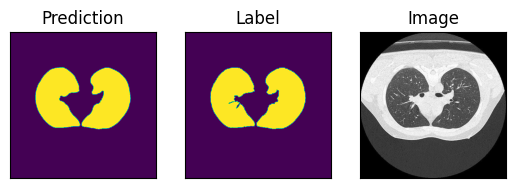

In [20]:
model = segmentation.SegmentationModel()

volume_i = 19
slice_i = 100
test_sample_image = Image.open(paths.PATH_LIST[volume_i][slice_i][0])
pred = model(test_sample_image)
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(pred.squeeze().cpu().numpy())
plt.xticks([])
plt.yticks([])
plt.title('Prediction')

plt.subplot(1, 3, 2)
label = Image.open(paths.PATH_LIST[volume_i][slice_i][1])
label = transform(label)
label = label[0:1, :, :]
label = label.bool()
label = label.squeeze().cpu().numpy()
plt.imshow(label)
plt.xticks([])
plt.yticks([])
plt.title('Label')

plt.subplot(1, 3, 3)
plt.imshow(test_sample_image)
plt.xticks([])
plt.yticks([])
plt.title('Image')

plt.show()

In [1]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 10868), started 0:02:39 ago. (Use '!kill 10868' to kill it.)

In [27]:
model = smp.DeepLabV3Plus(
    encoder_name='resnet34', 
    encoder_weights=None,
    in_channels=1,
    classes=1, 
    activation='sigmoid',
)
state_dict = torch.load(os.path.join(paths.MODEL_PATH, 'best_model_dlv3p.pth'))
model.load_state_dict(state_dict)
model = model.to(device)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=False,
)

In [28]:
test_logs = valid_epoch.run(test_dataloader)
print(f"Test loss: {test_logs['dice_loss']:.5f}, iou_score: {test_logs['iou_score']:.5f}")

Test loss: 0.01335, iou_score: 0.97387
